In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from pylab import *
import copy
import time

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all


# ----- Step 1: Set Hyper Parameters ----- #

model = 'LSTM'
dataset = 'ECG5000'
NAME = f'{model}-UCR-{dataset}'

train_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TRAIN.tsv'
test_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TEST.tsv'

BATCH_SIZE = 200  # 150
LR = 0.001

TIME_STEP = 140
INPUT_SIZE = 1
OUTPUT_SIZE = 5


# ----- Step 2: Dataset Loading and Preprocessing ----- #

class GetLoader(torch.utils.data.Dataset):      # 定义GetLoader类，继承Dataset方法

    def __init__(self, data_root, data_label):  # 初始化，加载数据
        self.data = data_root
        self.label = data_label

    def __getitem__(self, index):               # index是根据batchsize划分数据得到的索引
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    def __len__(self):                          # 返回数据大小长度，方便DataLoader划分
        return len(self.data)

    
train_text = ''
test_text = ''

train_x = []
train_y = []
test_x = []
test_y = []

with open(train_data_path, 'r') as f:
    train_text = f.read()
train_lines = train_text.split('\n')
for line in train_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        train_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        train_x.append(flo_list)

with open(test_data_path, 'r') as f:
    test_text = f.read()
test_lines = test_text.split('\n')
for line in test_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        test_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        test_x.append(flo_list)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

# for i in range(len(train_y)):  # special pre-processing bacause of the format of the original dataset
#     if train_y[i] == -1:
#         train_y[i] = 1
        
# for i in range(len(test_y)):
#     if test_y[i] == -1:
#         test_y[i] = 1

print('*** Dataset Information ***\ntrain_x:', train_x.shape, '\ntrain_y:', train_y.shape, '\ntest_x:', test_x.shape, '\ntest_y:', test_y.shape)


# 留作每50轮输出当前训练结果用
train_X = copy.deepcopy(train_x)
train_X = torch.from_numpy(train_X).to(torch.float32)
train_Y = copy.deepcopy(train_y)
test_X = torch.from_numpy(test_x).to(torch.float32)
test_Y = test_y

train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.long)
train_data = GetLoader(train_x, train_y)                # 返回Dataset对象(包含data和label)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_Y1 = copy.deepcopy(train_y)


# ----- Step 3: Create Model Class ----- #

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,
            num_layers=2,
            batch_first=True
        )
        self.out = nn.Linear(128, OUTPUT_SIZE)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])        # choose r_out at the last time step
        out_trace = self.out(r_out)            # choose r_out at all time steps
        return out, out_trace


# ----- Step 4: Instantiate ----- #

rnn = RNN()
print('\n*** Model Information ***\n', rnn, '\n\n*** Training Information ***')

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()   # the target label is not one-hotted


# ----- Step 5: Model Training ----- #

for turns in range(1, 201):
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        
        train_x = train_x.view(-1, TIME_STEP, INPUT_SIZE)
        output, _ = rnn(train_x)
        loss = loss_fn(output, train_y)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients

        train_output, _ = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)

        torch.save(rnn, f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        print('Epoch: ', turns, '_', batch_idx, '| train loss: %.6f' % train_loss.data.numpy(), '| train accuracy: %.4f' % train_accuracy)
        


*** Dataset Information ***
train_x: (500, 140, 1) 
train_y: (500,) 
test_x: (4500, 140, 1) 
test_y: (4500,)

*** Model Information ***
 RNN(
  (rnn): LSTM(1, 128, num_layers=2, batch_first=True)
  (out): Linear(in_features=128, out_features=5, bias=True)
) 

*** Training Information ***
Epoch:  1 _ 0 | train loss: 1.632468 | train accuracy: 0.0040
Epoch:  1 _ 1 | train loss: 1.601780 | train accuracy: 0.1180
Epoch:  1 _ 2 | train loss: 1.569709 | train accuracy: 0.3480
Epoch:  2 _ 0 | train loss: 1.534853 | train accuracy: 0.8400
Epoch:  2 _ 1 | train loss: 1.495720 | train accuracy: 0.8640
Epoch:  2 _ 2 | train loss: 1.450402 | train accuracy: 0.8780
Epoch:  3 _ 0 | train loss: 1.396323 | train accuracy: 0.8920
Epoch:  3 _ 1 | train loss: 1.330137 | train accuracy: 0.8940
Epoch:  3 _ 2 | train loss: 1.246619 | train accuracy: 0.9000
Epoch:  4 _ 0 | train loss: 1.139923 | train accuracy: 0.9040
Epoch:  4 _ 1 | train loss: 1.004119 | train accuracy: 0.9060
Epoch:  4 _ 2 | train loss: 0

Epoch:  43 _ 0 | train loss: 0.211935 | train accuracy: 0.9460
Epoch:  43 _ 1 | train loss: 0.206272 | train accuracy: 0.9440
Epoch:  43 _ 2 | train loss: 0.203227 | train accuracy: 0.9420
Epoch:  44 _ 0 | train loss: 0.202442 | train accuracy: 0.9420
Epoch:  44 _ 1 | train loss: 0.199217 | train accuracy: 0.9440
Epoch:  44 _ 2 | train loss: 0.195769 | train accuracy: 0.9440
Epoch:  45 _ 0 | train loss: 0.193088 | train accuracy: 0.9460
Epoch:  45 _ 1 | train loss: 0.199603 | train accuracy: 0.9460
Epoch:  45 _ 2 | train loss: 0.195105 | train accuracy: 0.9460
Epoch:  46 _ 0 | train loss: 0.198338 | train accuracy: 0.9400
Epoch:  46 _ 1 | train loss: 0.188396 | train accuracy: 0.9440
Epoch:  46 _ 2 | train loss: 0.187064 | train accuracy: 0.9460
Epoch:  47 _ 0 | train loss: 0.190588 | train accuracy: 0.9440
Epoch:  47 _ 1 | train loss: 0.188056 | train accuracy: 0.9440
Epoch:  47 _ 2 | train loss: 0.198016 | train accuracy: 0.9460
Epoch:  48 _ 0 | train loss: 0.203720 | train accuracy:

Epoch:  86 _ 2 | train loss: 0.116350 | train accuracy: 0.9640
Epoch:  87 _ 0 | train loss: 0.111226 | train accuracy: 0.9660
Epoch:  87 _ 1 | train loss: 0.116380 | train accuracy: 0.9660
Epoch:  87 _ 2 | train loss: 0.155663 | train accuracy: 0.9420
Epoch:  88 _ 0 | train loss: 0.120576 | train accuracy: 0.9600
Epoch:  88 _ 1 | train loss: 0.118841 | train accuracy: 0.9640
Epoch:  88 _ 2 | train loss: 0.146823 | train accuracy: 0.9560
Epoch:  89 _ 0 | train loss: 0.167270 | train accuracy: 0.9580
Epoch:  89 _ 1 | train loss: 0.163016 | train accuracy: 0.9520
Epoch:  89 _ 2 | train loss: 0.164394 | train accuracy: 0.9520
Epoch:  90 _ 0 | train loss: 0.162258 | train accuracy: 0.9520
Epoch:  90 _ 1 | train loss: 0.152175 | train accuracy: 0.9580
Epoch:  90 _ 2 | train loss: 0.142473 | train accuracy: 0.9620
Epoch:  91 _ 0 | train loss: 0.137407 | train accuracy: 0.9620
Epoch:  91 _ 1 | train loss: 0.131871 | train accuracy: 0.9600
Epoch:  91 _ 2 | train loss: 0.132614 | train accuracy:

Epoch:  129 _ 2 | train loss: 0.088549 | train accuracy: 0.9760
Epoch:  130 _ 0 | train loss: 0.086138 | train accuracy: 0.9740
Epoch:  130 _ 1 | train loss: 0.085311 | train accuracy: 0.9760
Epoch:  130 _ 2 | train loss: 0.085787 | train accuracy: 0.9740
Epoch:  131 _ 0 | train loss: 0.084835 | train accuracy: 0.9760
Epoch:  131 _ 1 | train loss: 0.084243 | train accuracy: 0.9760
Epoch:  131 _ 2 | train loss: 0.083566 | train accuracy: 0.9760
Epoch:  132 _ 0 | train loss: 0.082868 | train accuracy: 0.9760
Epoch:  132 _ 1 | train loss: 0.082525 | train accuracy: 0.9780
Epoch:  132 _ 2 | train loss: 0.081076 | train accuracy: 0.9760
Epoch:  133 _ 0 | train loss: 0.081358 | train accuracy: 0.9760
Epoch:  133 _ 1 | train loss: 0.080938 | train accuracy: 0.9760
Epoch:  133 _ 2 | train loss: 0.079670 | train accuracy: 0.9760
Epoch:  134 _ 0 | train loss: 0.079326 | train accuracy: 0.9780
Epoch:  134 _ 1 | train loss: 0.079897 | train accuracy: 0.9780
Epoch:  134 _ 2 | train loss: 0.078327 |

Epoch:  172 _ 2 | train loss: 0.063505 | train accuracy: 0.9820
Epoch:  173 _ 0 | train loss: 0.062521 | train accuracy: 0.9820
Epoch:  173 _ 1 | train loss: 0.060726 | train accuracy: 0.9840
Epoch:  173 _ 2 | train loss: 0.059291 | train accuracy: 0.9840
Epoch:  174 _ 0 | train loss: 0.058125 | train accuracy: 0.9860
Epoch:  174 _ 1 | train loss: 0.057944 | train accuracy: 0.9880
Epoch:  174 _ 2 | train loss: 0.057795 | train accuracy: 0.9880
Epoch:  175 _ 0 | train loss: 0.056804 | train accuracy: 0.9880
Epoch:  175 _ 1 | train loss: 0.055325 | train accuracy: 0.9880
Epoch:  175 _ 2 | train loss: 0.053872 | train accuracy: 0.9860
Epoch:  176 _ 0 | train loss: 0.052507 | train accuracy: 0.9860
Epoch:  176 _ 1 | train loss: 0.052976 | train accuracy: 0.9880
Epoch:  176 _ 2 | train loss: 0.051327 | train accuracy: 0.9880
Epoch:  177 _ 0 | train loss: 0.050575 | train accuracy: 0.9900
Epoch:  177 _ 1 | train loss: 0.050625 | train accuracy: 0.9900
Epoch:  177 _ 2 | train loss: 0.049868 |

In [2]:
"""
Finding The Optimum Model Automatically

"""

min_loss = 10000
max_test_acc = 0
corresponding_train_acc = 0

turns_chosen = -1
batch_idx_chosen = -1

for turns in range(1, 201):
    batch_number = int(train_X.shape[0]/BATCH_SIZE)
    if train_X.shape[0] % BATCH_SIZE != 0:
        batch_number += 1
    
    for batch_idx in range(1,2):
        rnn = torch.load(f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        
        train_output, _ = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)
        
        test_output, _ = rnn(test_X[:1000])
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y[:1000]).astype(int).sum()) / float(test_Y[:1000].size)
        
        test_acc_bias = test_accuracy - max_test_acc
        loss_bias = train_loss.data.numpy() - min_loss
        if test_acc_bias >= 0.01 or (test_acc_bias >= 0 and test_acc_bias < 0.01 and loss_bias < 0.1):
            max_test_acc = test_accuracy
            min_loss = train_loss.data.numpy()
            corresponding_train_acc = train_accuracy
            turns_chosen = turns
            batch_idx_chosen = batch_idx

print('*** The Optimum Model ***\nEpoch Index: ', turns_chosen, '_', batch_idx_chosen)
print('Train Loss: %.6f' % min_loss, '\nTrain Accuracy: %.4f' % corresponding_train_acc, '\nTest Accuracy: %.4f' % max_test_acc)


*** The Optimum Model ***
Epoch Index:  121 _ 1
Train Loss: 0.113766 
Train Accuracy: 0.9580 
Test Accuracy: 0.9980


In [3]:
"""
 *** RNN - WFA Extraction ***

"""

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# Set Hyper-parameter of WFA Establishment
T = 20
INPUT_DISTANCE_FACTOR = 0.5  # value range: (0,1], divide tokens in the content that grading size is micro compared with average distance

if OUTPUT_SIZE >= 3:
    K = 3
else:
    K = 2


# ----- Step 1: Input Tokens Abstraction ----- #
print(f"*** Step 1: Input Tokens Abstraction ***")

# Getting Normalized Alphabet
train_X_numpy = train_X.detach().numpy()
alphabet = copy.deepcopy(train_X_numpy)
min_token = np.min(alphabet)  # make sure the min token in the alphabet do not less than 0
alphabet -= min_token
max_token = np.max(alphabet)  # tokens normalization
alphabet /= max_token

# Finding T_alphabet
count = 0
sum_distance = 0
current_distance = np.zeros(train_X.shape[2])
for i in range(train_X.shape[0]):
    for j in range(train_X.shape[1]-1):
        for k in range(train_X.shape[2]):
            current_distance[k] += abs(train_X[i, j+1, k] - train_X[i, j, k])
average_distance = current_distance / (train_X.shape[0] * (train_X.shape[1]-1))
T_alphabet = 1
for i in range(train_X.shape[2]):
    T_alphabet *= int(10 / (INPUT_DISTANCE_FACTOR * average_distance[i]))  # the mult of T for each input feature (alphabet dimensionality)
print(f"T_alphabet: {T_alphabet}")

# Abstracting Input Tokens as k-DCP Format
k_DCP = np.floor(alphabet*(T_alphabet-1))
k_DCP = np.reshape(k_DCP, (-1, alphabet.shape[2]))
uniques = np.unique(k_DCP, axis=0)  # remove duplicates
abst_inputs_number = len(uniques)
print(f'Number of Abstracted Input Tokens: {abst_inputs_number}')

# Building Labelling Representation of Abstracted Input Tokens
abst_alphabet_labels = np.zeros(train_X.shape[0]*train_X.shape[1]).astype(int)
for i in range(len(uniques)):
    j = findByRow(k_DCP, uniques[i, :])
    abst_alphabet_labels[j] = i
abst_alphabet_labels = np.reshape(abst_alphabet_labels, (train_X.shape[0], train_X.shape[1]))


# ----- Step 2: RNN Hidden States Abstraction (Under Sequential Inputs) ----- #
print('\n*** Step 2: RNN Hidden States Abstraction ***')

# Extracting Hidden States from the Optimum Model
rnn = torch.load(f'../Models/{NAME}/epoch_{turns_chosen}_{batch_idx_chosen}.pkl')
train_output, train_output_trace = rnn(train_X)

# Normaling Hidden States to Probability Distribution Format
train_output_trace = F.softmax(train_output_trace, dim=2)  # softmax in last dim
states = train_output_trace.detach().numpy() #

# Abstracting the (Prob) States as k-DCP Format
print(f'An Example:\n - Original State: {states[0, 0, :]}')
sorted_states = -np.sort(-states)[:, :, :K]  # (samples, timesteps, fatures)

sorted_states_index = np.argsort(-states)[:, :, :K]  # (samples, timesteps, fatures)
print(f' - Corresponding Prediction Label: {sorted_states_index[0, 0, :]}')

sorted_states_t = np.floor(sorted_states*(T-1))
print(f' - Corresponding Confidence Level: {sorted_states_t[0, 0, :]}')

k_DCP = np.append(sorted_states_index, sorted_states_t, axis=2)  # (samples, timesteps, 2*K)
print(f' - Abstracted State: {k_DCP[0, 0, :]}')

k_DCP = np.reshape(k_DCP, (-1, 2*K))
uniques = np.unique(k_DCP, axis=0)  # remove duplicates
abst_states_number = len(uniques)
print(f'Number of Abstracted States: {abst_states_number}')

# Building Labelling Representation of the States
abst_states_labels = np.zeros(train_X.shape[0]*train_X.shape[1]).astype(int)  # (samples, timesteps)
for i in range(len(uniques)):
    j = findByRow(k_DCP, uniques[i, :])
    abst_states_labels[j] = i
abst_states_labels = np.reshape(abst_states_labels, (train_X.shape[0], train_X.shape[1]))  # (samples, timesteps)
abst_states_labels = abst_states_labels + 1  # Leaving the index 0 for the Intinal Status of WFA




"""
Step3 - Intinal Vector Establishment 

"""

# ----- Initial Vector Establishment ----- #

initial_vector = np.zeros(abst_states_number+1)
initial_vector[0] = 1

print('\nShape of Initial Vector:\n', initial_vector.shape)
print('Initial Vector:\n', initial_vector)



"""
Step4 - Transition Matrixes Establishment

"""

# ----- Non-probabilistic Transition Matrixes Establishment ----- #

non_prob_transition_matrixes = np.zeros((abst_inputs_number, abst_states_number+1, abst_states_number+1))

for item in range(abst_inputs_number):  # for every abstract token
    for i_0 in range(train_X.shape[0]):
        for i_1 in range(train_X.shape[1]):  # for every token
            if abst_alphabet_labels[i_0, i_1] == item:
                if i_1 == 0:   # confirm front abstract state
                    front_abst_state = 0
                else:
                    front_abst_state = int(abst_states_labels[i_0, i_1-1])

                back_abst_state = int(abst_states_labels[i_0, i_1])  # confirm back abstract state
                non_prob_transition_matrixes[item, front_abst_state, back_abst_state] += 1  # add a transition edge

print('\nShape of Non_prob_transition_matrixes:\n', non_prob_transition_matrixes.shape)
print('Sample of a Non-prob Transition Matrix:\n', non_prob_transition_matrixes[0, :, :])


# ----- Probabilistic Transition Matrixes Establishment ----- #

for item in range(abst_inputs_number):
#     i_matrix = non_prob_transition_matrixes[item, :, :]
#     i_sum = np.sum(i_matrix)
#     non_prob_transition_matrixes[item, :, :] /= i_sum
    for i in range(non_prob_transition_matrixes.shape[1]):
        i_sum = np.sum(non_prob_transition_matrixes[item, i, :])
        if i_sum != 0:
            non_prob_transition_matrixes[item, i, :] /= i_sum
        

print('Shape of Prob_transition_matrixes:\n', non_prob_transition_matrixes.shape)
print('Sample of a Prob Transition Matrix:\n', non_prob_transition_matrixes[0, :, :])
print('Sum of the Element of the Sample Prob Transition Matrix:\n', np.sum(non_prob_transition_matrixes[0, :, :]))

# np.save(f"../WFAs/{NAME}/non_prob_transition_matrixes.npy", non_prob_transition_matrixes)



"""
Step5 - Final Vector Establishment 

"""

# ----- Initial Vector Establishment ----- #

initial_vector = np.zeros(abst_states_number+1)
initial_vector[0] = 1

print('\nShape of Initial Vector:\n', initial_vector.shape)
print('Initial Vector:\n', initial_vector)


# ----- (Non-probabilistic) Final Vectors Establishment ----- #

non_prob_final_vector = np.zeros([abst_states_number+1, OUTPUT_SIZE])

for i_0 in range(train_X.shape[0]):
    for i_1 in range(train_X.shape[1]):  # for every state
        state_class = np.argsort(-states[i_0, i_1, :])[0]    # the class of state in original problem
        abst_label = int(abst_states_labels[i_0, i_1])       # the abst label of state
        non_prob_final_vector[abst_label, state_class] += 1  # corresponding class count++

print('\nShape of (Non-prob) Final Vector:\n', non_prob_final_vector.shape)
print('(Non-prob) Final Vector:\n', non_prob_final_vector)


# ----- (Probabilistic) Final Vectors Establishment ----- #

final_vector = np.zeros([abst_states_number+1, OUTPUT_SIZE])

output_0 = np.zeros(OUTPUT_SIZE)  # create abstract state 0 ([0.333 0.333 0.333])
output_0_tensor = torch.from_numpy(output_0)
state_0_tensor = F.softmax(output_0_tensor)
state_0 = state_0_tensor.detach().numpy()
final_vector[0, :] = state_0

for item in range(1, abst_states_number+1):  # for every abstract state
    item_classes = non_prob_final_vector[item, :]
    item_sum = np.sum(item_classes)                  # count the num of all the classes
    final_vector[item, :] = item_classes / item_sum  # count the probabilistic of every class

print('\nShape of (Prob) Final Vector:\n', final_vector.shape)
print('(Prob) Final Vector:\n', final_vector)


*** Step 1: Input Tokens Abstraction ***
T_alphabet: 133
Number of Abstracted Input Tokens: 120

*** Step 2: RNN Hidden States Abstraction ***
An Example:
 - Original State: [0.20460752 0.2260449  0.19247438 0.18334673 0.19352657]
 - Corresponding Prediction Label: [1 0 4]
 - Corresponding Confidence Level: [4. 3. 3.]
 - Abstracted State: [1. 0. 4. 4. 3. 3.]
Number of Abstracted States: 2006

Shape of Initial Vector:
 (2007,)
Initial Vector:
 [1. 0. 0. ... 0. 0. 0.]

Shape of Non_prob_transition_matrixes:
 (120, 2007, 2007)
Sample of a Non-prob Transition Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of Prob_transition_matrixes:
 (120, 2007, 2007)
Sample of a Prob Transition Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Sum of the Element of the 

<ipython-input-3-d76595e20fb4>:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  state_0_tensor = F.softmax(output_0_tensor)


In [4]:
"""
Evaluation of Models' Running Time and Accuracy

"""

# ----- Original RNN Evaluation ----- #

print('*** Evaluation of Original RNN ***')

time_start = time.time()  # time start
rnn_output, _ = rnn(train_X)
time_end = time.time()  # time end
print('Running Time: %fs' % (time_end - time_start))

rnn_pred_train_y = torch.max(rnn_output, 1)[1].data.numpy()
rnn_train_accuracy = float((rnn_pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
print('Accuracy (Train): %.4f' % rnn_train_accuracy)


# ----- WFA Evaluation ----- #

time_count = 0.0

WFA_output = np.zeros([train_X.shape[0], OUTPUT_SIZE])

for i_0 in range(train_X.shape[0]):
    output = initial_vector

    for i_1 in range(train_X.shape[1]):
#         print(output)
        index = int(abst_alphabet_labels[i_0, i_1])  # confirm the abst label of the token case
#         if i_1 == 1:
#             index += 1
        transition_matrix = non_prob_transition_matrixes[index, :, :]  # (the name remain unchanged to save the storage space)

        time_start = time.time()  # time start
        output = np.matmul(output, transition_matrix)
        time_end = time.time()  # time end
        time_count += time_end - time_start
        
#         output /= output.sum()  # set the sum of elements of status vector is 1 in every single timestep

    time_start = time.time()  # time start
    output = np.matmul(output, final_vector)
    time_end = time.time()  # time end
    time_count += time_end - time_start

    WFA_output[i_0, :] = output


print('\n*** Evaluation of WFA ***')
print('Running Time: %fs' % time_count)

wfa_output = torch.from_numpy(WFA_output)  # transform to tensor
wfa_pred_train_y = torch.max(wfa_output, 1)[1].data.numpy()
wfa_train_accuracy = float((wfa_pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
print('Accuracy (Train): %.4f' % wfa_train_accuracy)


# ----- Similarity of the Models ----- #

print('\n*** Similarity ***')

differ_record = []
for i_0 in range(train_X.shape[0]):
    if wfa_pred_train_y[i_0] != rnn_pred_train_y[i_0]:
        differ_record.append(i_0)
        print(f'\nRNN Output: {rnn_output[i_0, :]}')
        print(f'WFA Output: {wfa_output[i_0, :]}')
        print(f'Correct Lable: {train_Y[i_0]}')

similarity = (1 - len(differ_record) / train_X.shape[0])*100
print('\nSimilarity between WFA and RNN: %.2f' % similarity, '%')


*** Evaluation of Original RNN ***
Running Time: 2.118197s
Accuracy (Train): 0.9580

*** Evaluation of WFA ***
Running Time: 100.156666s
Accuracy (Train): 0.9360

*** Similarity ***

RNN Output: tensor([ 1.2088, -2.1377, -0.3192,  1.2613, -1.2673], grad_fn=<SliceBackward0>)
WFA Output: tensor([1.3369e-04, 0.0000e+00, 0.0000e+00, 2.2140e-05, 0.0000e+00],
       dtype=torch.float64)
Correct Lable: 0.0

RNN Output: tensor([ 5.7106, -1.8398, -3.0990, -2.0853, -0.3516], grad_fn=<SliceBackward0>)
WFA Output: tensor([2.3994e-05, 4.3195e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64)
Correct Lable: 0.0

RNN Output: tensor([ 5.4735, -1.8974, -2.5713, -2.1656,  0.0061], grad_fn=<SliceBackward0>)
WFA Output: tensor([0.0001, 0.0002, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
Correct Lable: 0.0

RNN Output: tensor([-3.5232,  5.0712, -1.9877,  2.9558, -2.1820], grad_fn=<SliceBackward0>)
WFA Output: tensor([2.5374e-06, 4.9397e-08, 0.0000e+00, 0.0000e+00, 3.1119e-11],
       d


Original Adversarial Sample: Input Sample [9]
RNN Output: tensor([ 1.2088, -2.1377, -0.3192,  1.2613, -1.2673], grad_fn=<SliceBackward0>)
WFA Output: tensor([1.3369e-04, 0.0000e+00, 0.0000e+00, 2.2140e-05, 0.0000e+00],
       dtype=torch.float64)
Correct Lable: 0.0


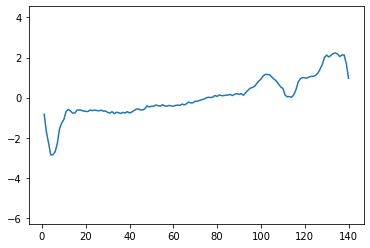

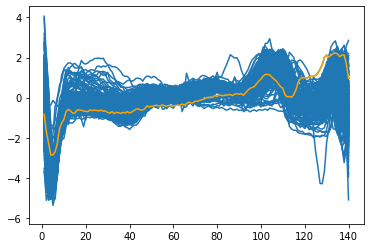

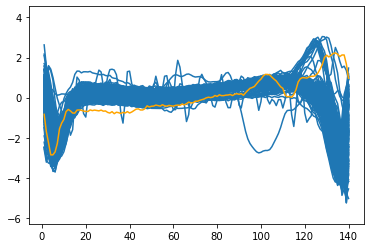

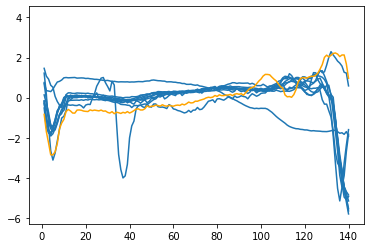

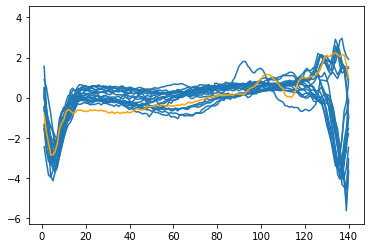

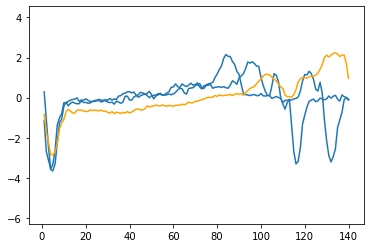

In [5]:
"""
Finding Original Adversarial Samples

"""

ylim_low = 65535  # calculate the range of the plotted figure
ylim_high = 0
for item in train_X:
    for ts in range(TIME_STEP):
        if item[ts, 0] > ylim_high:
            ylim_high = item[ts, 0]
        if item[ts, 0] < ylim_low:
            ylim_low = item[ts, 0]
input_distance = ylim_high - ylim_low
plot_distance = (input_distance) / 10  # calculate the plot distance under the dataset

timestep_record = [i for i in range(1, TIME_STEP+1)]
for i in differ_record:
    if rnn_pred_train_y[i] != train_Y[i] and wfa_pred_train_y[i] == train_Y[i]:        
        print(f'\nOriginal Adversarial Sample: Input Sample [{i}]')
#         print(train_X[i])
        print(f'RNN Output: {rnn_output[i, :]}')
        print(f'WFA Output: {wfa_output[i, :]}')
        print(f'Correct Lable: {train_Y[i]}')
        
        adv_X_record = []  # plot current original adversarial sample
        for item in np.array(train_X[i]):
            adv_X_record.append(item[0])
        plt.plot(timestep_record, adv_X_record)
        plt.ylim((ylim_low-plot_distance/2, ylim_high+plot_distance/2))
        plt.show()
     
        for j in range(OUTPUT_SIZE):  # plot all the classes as reference objects respectively
            for k in range(train_X.shape[0]):
                if train_Y[k] == j:
                    X_record = []
                    for item in np.array(train_X[k]):
                        X_record.append(item[0]) 
                    plt.plot(timestep_record, X_record, color='#1f77b4')
            plt.plot(timestep_record, adv_X_record, color='orange')
            plt.ylim((ylim_low-plot_distance/2, ylim_high+plot_distance/2))
            plt.show()


In [6]:
"""
Adversarial Samples Generation

"""

# ----- Set Hyper-parameter of Perturbation ----- #

SAMPLING_GRAIN = 10  # sampling grain size for each iteration, do not need to change normally

PERTURBATION_FACTOR = 1  # value range: (0,1], bigger value means larger perturbation under the limitation of 'micro'
PERTURBATION_WINDOW_FACTOR = 1  # value range: (0,1], bigger value means larger window size under the limitation of 'micro'

perturbation_range = PERTURBATION_FACTOR * (average_distance / 10)
perturbation_window_size = int(PERTURBATION_WINDOW_FACTOR * (TIME_STEP / 10))


# ----- Finding Minimum Positive Sample ----- #

original_adv_X_set = []
parent_adv_X_set = []
parent_adv_Y_set = []

for i in differ_record:
    if rnn_pred_train_y[i] != train_Y[i] and wfa_pred_train_y[i] == train_Y[i]:
        print("==========", i)
        abst_bias = []
        for k in range(train_X.shape[0]):
            current_abst_bias = 0
            for j in range(train_X.shape[1]):
                current_abst_bias += abs(int(abst_alphabet_labels[k,j])-int(abst_alphabet_labels[i,j]))
            abst_bias.append(current_abst_bias)
        candidate_samples_index = np.argsort(abst_bias)
        
        ### 可以多取几个
        for candidate_sample_index in candidate_samples_index:
            if rnn_pred_train_y[candidate_sample_index] != train_Y[candidate_sample_index] or train_Y[candidate_sample_index] != train_Y[i]:
                continue
            
            minimum_positive_sample = train_X[candidate_sample_index]
            current_negative_X = copy.deepcopy(np.array(train_X[i]))
#             print(candidate_sample_index)
#             print(minimum_positive_sample)
#             print(current_negative_X)
            
            # iterative sampling in variable pos-neg range
            while True:
                sampled_instant_X_set = []
                sampled_instant_Y_set = []

                # build sampler
                sampling_bias_x = []
                for j in range(train_X.shape[1]):
                    sampling_bias_x_2 = []
                    for k in range(train_X.shape[2]):
                        real_bias = minimum_positive_sample[j,k] - current_negative_X[j,k]
                        sampling_bias = real_bias / SAMPLING_GRAIN
                        sampling_bias_x_2.append(sampling_bias)   
                    sampling_bias_x.append(sampling_bias_x_2)
                sampling_bias_x = np.array(sampling_bias_x)
#                 print(sampling_bias_x)
            
                # sampling
                sampled_instant_X = copy.deepcopy(current_negative_X)
                for j in range(SAMPLING_GRAIN+1):
                    sampled_instant_X_set.append(copy.deepcopy(sampled_instant_X))
                    sampled_instant_Y_set.append(train_Y[i])
                    sampled_instant_X += sampling_bias_x
#                 print(sampled_instant_X_set)

                # find pos and neg distrubution
                sampled_instant_X_set = np.array(sampled_instant_X_set)
                sampled_instant_Y_set = np.array(sampled_instant_Y_set)
                sampled_instant_X_set = torch.from_numpy(sampled_instant_X_set).to(torch.float32)
                sampled_instant_output, _ = rnn(sampled_instant_X_set)
                pred_sampled_instant_y = torch.max(sampled_instant_output, 1)[1].data.numpy()
                sampled_instant_acc_record = (pred_sampled_instant_y == sampled_instant_Y_set)
                
                # update pos-neg range
                for j in range(len(sampled_instant_acc_record)-1):
                    print(sampled_instant_acc_record[j])
                    if not sampled_instant_acc_record[j] and sampled_instant_acc_record[j+1]:
                        current_negative_X = copy.deepcopy(np.array(sampled_instant_X_set[j]))
                        minimum_positive_sample = copy.deepcopy(np.array(sampled_instant_X_set[j+1]))
                    
                # end condition
                end_flag = True
                for j in range(train_X.shape[2]):
                    if sampling_bias_x[:, j].max() > perturbation_range[j] / 10:  # 停止条件取 perturbation_range 的多少合适？
                        end_flag = False
                if end_flag:  
                    original_adv_X_set.append(train_X[candidate_sample_index])
                    parent_adv_X_set.append(minimum_positive_sample)
                    parent_adv_Y_set.append(train_Y[i])
                    break
            
            break
        
           
# ----- Adversarial Samples Generation ----- #

adv_X_set = []
adv_Y_set = []        

for i in range(len(parent_adv_X_set)):
    parent_adv_X = parent_adv_X_set[i]
    parent_adv_Y = parent_adv_Y_set[i]
    
    adv_X = []
    for j in range(TIME_STEP-perturbation_window_size+1):
        current_adv_X_1 = copy.deepcopy(parent_adv_X)
        current_adv_X_2 = copy.deepcopy(parent_adv_X)

        for k in range(perturbation_window_size):
            for t in range(train_X.shape[2]):  # perturbation distance is different for each feature (dimensionality)
                current_adv_X_1[j+k][t] -= perturbation_range[t]
                current_adv_X_2[j+k][t] += perturbation_range[t]  # two perturbation method + and -
        
        adv_X.append(np.array(current_adv_X_1))
        adv_X.append(np.array(current_adv_X_2))

    adv_Y = [parent_adv_Y for j in range(len(adv_X))]

    adv_X_set.extend(adv_X)
    adv_Y_set.extend(adv_Y)

    single_adv_X_set_len = len(adv_X)

print(f'The Number of Adversarial Samples Generated: {len(adv_X_set)}')


# ----- Adversarial Attack Evaluation and Illustration----- #

if not adv_X_set:
    print('Success Rate of Adversarial Attack: 0 %')
else:
    adv_X_set = np.array(adv_X_set)
    adv_Y_set = np.array(adv_Y_set)
    adv_X_set = torch.from_numpy(adv_X_set).to(torch.float32)
    adv_output, _ = rnn(adv_X_set)
    pred_adv_y = torch.max(adv_output, 1)[1].data.numpy()
    adv_accuracy = float((pred_adv_y == adv_Y_set).astype(int).sum()) / float(adv_Y_set.size)
    print('Success Rate of Adversarial Attack: %.2f' % ((1-adv_accuracy)*100), '%')
    
    test_acc_num = (pred_test_y == test_Y).astype(int).sum()
    adv_acc_num = (pred_adv_y == adv_Y_set).astype(int).sum()
    test_adv_total_num = test_Y.size + adv_Y_set.size
    attacked_test_accuracy = float(test_acc_num + adv_acc_num) / float(test_adv_total_num)
    print('Attacked RNN Test Accuracy: %.4f' % attacked_test_accuracy)

    for i in range(len(parent_adv_X_set)):
        for j in range(i*single_adv_X_set_len, (i+1)*single_adv_X_set_len):  # for every adversarial samples generated under an original adv X
            if pred_adv_y[j] != adv_Y_set[j]:
                for k in range(train_X.shape[0]):  # samples in train X who have the same correct label of the original adv X
                    if train_Y[k] == adv_Y_set[i*single_adv_X_set_len]:
                        X_record = []
                        for item in np.array(train_X[k]):
                            X_record.append(item[0]) 
                        plt.plot(timestep_record, X_record, color='#1f77b4')#np.array(train_X[i])

                plt.plot(timestep_record, original_adv_X_set[i], color='purple')  # the specific original adv X as reference object
                plt.plot(timestep_record, adv_X_set[j], color='red')
                plt.plot(timestep_record, parent_adv_X_set[i], color='orange')  # the specific original adv X as reference object
                plt.ylim((ylim_low-plot_distance/2, ylim_high+plot_distance/2))
                plt.show()
                
### + 专家评估

========== 9
False
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
True
True
The Number of Adversarial Samples Generated: 254
Success Rate of Adversarial Attack: 43.70 %


<ipython-input-6-8bbb72303943>:144: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  test_acc_num = (pred_test_y == test_Y).astype(int).sum()


AttributeError: 'bool' object has no attribute 'astype'

In [16]:
test_output = []
pred_test_y = []
test_output, _ = rnn(test_X[:1000])
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_test_y == test_Y[:1000]).astype(int).sum()) / float(test_Y[:1000].size)
print(test_accuracy)

0.999


In [17]:
test_output = []
pred_test_y = []
test_output, _ = rnn(test_X[1000:2000])
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_test_y == test_Y[1000:2000]).astype(int).sum()) / float(test_Y[1000:2000].size)
print(test_accuracy)

1.0


In [18]:
test_output = []
pred_test_y = []
test_output, _ = rnn(test_X[2000:3000])
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_test_y == test_Y[2000:3000]).astype(int).sum()) / float(test_Y[2000:3000].size)
print(test_accuracy)

0.925


In [19]:
test_output = []
pred_test_y = []
test_output, _ = rnn(test_X[3000:4000])
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_test_y == test_Y[3000:4000]).astype(int).sum()) / float(test_Y[3000:4000].size)
print(test_accuracy)

0.822


In [20]:
test_output = []
pred_test_y = []
test_output, _ = rnn(test_X[4000:])
pred_test_y = torch.max(test_output, 1)[1].data.numpy()
test_accuracy = float((pred_test_y == test_Y[4000:]).astype(int).sum()) / float(test_Y[4000:].size)
print(test_accuracy)

0.848


In [7]:
import csv

adv_X_set = np.array(adv_X_set)
adv_Y_set = np.array(adv_Y_set)

with open(f'../UCR-Adv/{dataset}-Adv.tsv', 'w', newline='') as f:
    tsv_w = csv.writer(f, delimiter='\t')
    for i in range(adv_X_set.shape[0]):
        current_row = [adv_Y_set[i] for k in range(adv_X_set.shape[1]+1)]
        for j in range(adv_X_set.shape[1]):
            current_row[j+1] = adv_X_set[i, j, 0]
        tsv_w.writerow(current_row)  
